In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = [16,9]

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from scipy.stats import norm

import seaborn as sns

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM, GRU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [3]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected = True)
import plotly.graph_objs as go
# import plotly.figure_factory as ff

In [4]:
ori_data = pd.read_csv('../input/well-performance/Well_data.csv')
ori_data.sample(10)

,6/2/2014,902.83,29.26,Unnamed: 3,0,4786.92,0.1,0.2
28,7/1/2014,443.13,41.13,0.00,601,2979.47,0,1213.67
106,9/17/2014,438.52,43.93,0.00,358,3009.44,0,1345.62
1247,11/1/2017,170.58,64.17,81.94,922,2740.82,488,344.81
498,10/14/2015,196.11,67.89,38.87,384,2821.96,0,987.27
466,9/12/2015,210.87,49.36,33.47,177,2820.12,0,1107.96
803,8/14/2016,235.97,63.08,57.77,767,2821.00,400,713.27
1490,7/2/2018,249.65,56.39,86.93,566,2800.32,1000,215.48
920,12/9/2016,201.11,68.04,61.28,695,2700.51,142,758.34
666,3/30/2016,222.73,57.46,45.26,451,3043.49,0,666.78
217,1/6/2015,303.37,50.29,3.49,269,2864.60,0,1225.19


In [5]:
ori_data.columns = ['date', 'whfp', 'whft', 'wct', 'gor', 'bhp', 'gl_rate', 'q_rate']

In [6]:
whfp = go.Scatter(
    x = ori_data['date'],
    y = ori_data['whfp'],
    mode = "lines",
    name = "whfp",
)

whft = go.Scatter(
    x = ori_data['date'],
    y = ori_data['whft'],
    mode = "lines",
    name = "whft",
)

wct = go.Scatter(
    x = ori_data['date'],
    y = ori_data['wct'],
    mode = "lines",
    name = "wct",
)

gor = go.Scatter(
    x = ori_data['date'],
    y = ori_data['gor'],
    mode = "lines",
    name = "gor",
)

gl_rate = go.Scatter(
    x = ori_data['date'],
    y = ori_data['gl_rate'],
    mode = "lines",
    name = "gl_rate",
)

bhp = go.Scatter(
    x = ori_data['date'],
    y = ori_data['bhp'],
    mode = "lines",
    name = "bhp",
)

wct = go.Scatter(
    x = ori_data['date'],
    y = ori_data['wct'],
    mode = "lines",
    name = "wct",
)

q_rate = go.Scatter(
    x = ori_data['date'],
    y = ori_data['q_rate'],
    mode = "lines",
    name = "q_rate",
)

all_data = [whfp, whft, wct, gor, bhp, gl_rate, q_rate]

iplot(all_data, filename="Filename")

In [7]:
calibrated = pd.read_csv('../input/calibrated/calibrated.csv')

In [8]:
c = go.Scatter(
    x = calibrated['date'],
    y = calibrated['q_oil'],
    mode = "lines"
)

iplot([c], filename='filename')

In [9]:
oil = ori_data[['date', 'wct', 'gor', 'bhp', 'gl_rate', 'q_rate']]

In [10]:
oil.isnull().sum()

date        0
wct        42
gor         0
bhp         3
gl_rate     0
q_rate      0
dtype: int64

In [11]:
gl_rate = go.Scatter(
    x = oil['date'],
    y = oil["gl_rate"],
    mode = "lines",
)

iplot([gl_rate], filename="filename")

In [12]:
def smooth(data, x, f):
    '''
    Make data is more reliable, get rid of outlier.
    x: int,
        Divide sub-dataset from input data
    f: str,
        Feature of data want to process
    '''
    length = 100
    df_new = []
    for i in range(x):
        if i == (x - 1):
            df = data[length * i:]
        else:
            df = data[length * i: length * (i + 1)]
        df = df.reset_index().drop('index', axis=1)
        mean = df[f].mean()
        for j in range(len(df)):
            if df[f][j] > mean + 300 or df[f][j] < mean - 300:
                df[f][j] = mean + np.random.randint(-30, 30)
        df_new.append(df)
    return df_new

In [13]:
gaslift = oil[['date', 'gl_rate']]

In [14]:
cali = smooth(gaslift, 17, 'gl_rate')

In [15]:
df_cali = pd.concat(cali, axis=0)
df_cali = df_cali.reset_index().drop('index', axis=1)

In [16]:
n = go.Scatter(
    x = df_cali['date'],
    y = df_cali['gl_rate'],
    mode = "lines",
)

iplot([n], filename="filename")

In [17]:
gor = oil[['date', 'gor']]

In [18]:
cali_gor = smooth(gor, 17, 'gor')

In [19]:
gor_cl = pd.concat(cali_gor, axis=0)
gor_cl = gor_cl.reset_index().drop('index', axis=1)

In [20]:
gor = go.Scatter(
    x = gor_cl['date'],
    y = gor_cl['gor'],
    mode = "lines",
)
iplot([gor], filename = "filename")

In [21]:
f_data = pd.concat([oil['date'], df_cali['gl_rate'], gor_cl['gor'], oil['wct'], oil['q_rate']], axis=1)

In [22]:
f_data['wct'] = f_data['wct'].fillna(f_data['wct'].mean())

In [23]:
q_oil = calibrated['q_oil'][689:]
q_oil.reset_index(drop=True, inplace=True)

In [24]:
f = f_data[690:]
f.reset_index(drop=True, inplace=True)
f = pd.concat([f, q_oil], axis=1)
f.drop('q_rate', axis=1, inplace=True)
f.head()

,date,gl_rate,gor,wct,q_oil
0,4/23/2016,70,525,49.09,843.59
1,4/24/2016,150,477,49.77,836.69
2,4/25/2016,200,469,49.66,842.81
3,4/26/2016,200,515,48.87,849.36
4,4/27/2016,36,495,49.93,827.09


In [25]:
# from sklearn.utils import shuffle
# fs = shuffle(f)

In [26]:
# sns.distplot(fs['gl_rate'], fit=norm)

In [27]:
# scaler = MinMaxScaler()
# f_scaled = scaler.fit_transform(fs.values)

In [28]:
# X = f_scaled[:, :-1]
# y = f_scaled[:, -1]

In [29]:
# X_test, y_test = X[800:], y[800:]
# print(X_test.shape, y_test.shape)

In [30]:
# X_train, X_valid, y_train, y_valid = train_test_split(X[:800], y[:800], test_size=0.2)
# print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

In [31]:
# model = Sequential()
# model.add(Dense(8, input_shape=(4, ), activation='relu'))
# # model.add(Dense(4, activation='relu'))
# model.add(Dense(1))
# model.compile(loss='mse', optimizer='rmsprop')
# model.summary()

In [32]:
# h = model.fit(X_train, y_train,
#              epochs=100,
#              batch_size=2,
#              validation_data=[X_valid, y_valid],
#              verbose = 1)

In [33]:
# plt.plot(h.history['loss'], label='loss')
# plt.plot(h.history['val_loss'], label='val_loss')
# plt.legend()
# plt.show()

In [34]:
# y_pred = model.predict(X_test)

In [35]:
# mse(y_test, y_pred)

In [36]:
# r2(y_test, y_pred)

In [37]:
# fy = pd.DataFrame({'x': y_test,
#                    'y': y_pred.flatten()})
# l1 = go.Scatter(
#     x = fy['x'],
#     y = fy['y'],
#     mode = "markers",
# )

# iplot([l1], filename = "filename")

In [38]:
def TanhScaler(data, copy=True):
    '''
    Scale data to make better results.
    data: dataset want to scale,
    copy: boolean, optional, default True
        Copy new data from original data.
    '''
    if copy:
        df = data.copy()
    cols = df.columns
    new  = list()
    for col in cols:
        mu    = np.mean(df[col])
        sigma = np.std(df[col])
        z     = list()
        for i in df[col]:
            xi = 0.5 * (np.tanh(0.01 * (i - mu) / sigma) + 1)
            z.append(xi)
        z = np.array(z).reshape(-1, 1)
        new.append(z)
        
    new    = np.concatenate(new, axis=1)
    df     = pd.DataFrame(data   = new,
                         columns = cols)
    return df

In [39]:
def shift_convert(df, target, step=1, copy=True):
    '''
    Convert data to supervised learning
    df: DataFrame
        Data want to convert,
    target: Output of model,
    step: How far data can predict,
    copy: copy new data from original data.
    '''
    if copy:
        data = df.copy()
    data['new_fea'] = data[target]
    cols            = data.columns
    for col in cols:
        if col == target:
            pass
        else:
            data[col] = data[col].shift(step)
    return data

In [40]:
re = shift_convert(f, 'q_oil')

In [41]:
re.dropna(inplace=True)

In [42]:
re['oil_rate'] = re['q_oil']
re.drop('q_oil', axis=1, inplace=True)

In [43]:
re.reset_index(inplace=True)
re.drop('index', axis=1, inplace=True)

In [44]:
re.head()

,date,gl_rate,gor,wct,new_fea,oil_rate
0,4/23/2016,70.0,525.0,49.09,843.59,836.69
1,4/24/2016,150.0,477.0,49.77,836.69,842.81
2,4/25/2016,200.0,469.0,49.66,842.81,849.36
3,4/26/2016,200.0,515.0,48.87,849.36,827.09
4,4/27/2016,36.0,495.0,49.93,827.09,819.58


In [45]:
re = re.sample(re.shape[0])

In [46]:
X = re.values[:, 1:-1]
y = re.values[:, -1]

In [47]:
X_test = X[800:]
y_test = y[800:]
date = re['date'][800:].astype('datetime64')

In [48]:
X_train, X_valid, y_train, y_valid = train_test_split(X[:800], y[:800], test_size=0.2)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(640, 4) (640,) (160, 4) (160,)


In [49]:
# X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
# X_valid = X_valid.reshape((X_valid.shape[0], 1, X_valid.shape[1]))
# X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [50]:
# m2 = Sequential()
# m2.add(LSTM(20, input_shape=(X_train.shape[1], X_train.shape[2])))
# m2.add(Dense(1, activation='linear'))
# m2.compile(loss='mse', optimizer='adam')
# m2.summary()

In [51]:
# h = m2.fit(X_train, y_train,
#           epochs          = 200,
#           batch_size      = 10,
#           validation_data = [X_valid, y_valid],
#           verbose         = 1)

In [52]:
m1 = Sequential()
m1.add(Dense(5, input_shape=(4, ), activation='relu'))
# m1.add(Dense(4, activation='relu'))
m1.add(Dense(1))
m1.compile(loss='mse', optimizer='adam')
m1.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 25        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


In [53]:
h = m1.fit(X_train, y_train,
           epochs          = 100,
           batch_size      = 2,
           validation_data = [X_valid, y_valid],
           verbose         = 1)

Instructions for updating:
Use tf.cast instead.
Train on 640 samples, validate on 160 samples
Epoch 1/100
640/640 [==============================] - 3s 5ms/step - loss: 251947.9201 - val_loss: 56021.1083
Epoch 2/100
640/640 [==============================] - 1s 1ms/step - loss: 31429.4742 - val_loss: 12107.1526
Epoch 3/100
640/640 [==============================] - 1s 1ms/step - loss: 6302.1507 - val_loss: 2889.1973
Epoch 4/100
640/640 [==============================] - 1s 1ms/step - loss: 1839.4559 - val_loss: 1663.1137
Epoch 5/100
640/640 [==============================] - 1s 1ms/step - loss: 1298.5641 - val_loss: 1425.9868
Epoch 6/100
640/640 [==============================] - 1s 1ms/step - loss: 1162.4641 - val_loss: 1319.0062
Epoch 7/100
640/640 [==============================] - 1s 1ms/step - loss: 1066.6017 - val_loss: 1230.4217
Epoch 8/100
640/640 [==============================] - 1s 1ms/step - loss: 965.1178 - val_loss: 1210.5256
Epoch 9/100
640/640 [=========================

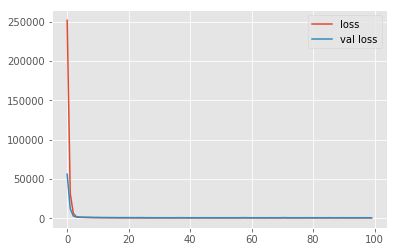

In [54]:
plt.plot(h.history['loss'], label="loss")
plt.plot(h.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [55]:
y_pred = m1.predict(X_test).flatten()

In [56]:
np.sqrt(mse(y_test, y_pred))

29.62063089680221

In [57]:
r2(y_test, y_pred)

0.9855041076447995

In [58]:
t = pd.DataFrame({'date': date,
                 'x': y_test,
                 'y': y_pred})
t['x'] = t['x'].astype('float32')
t.sort_values(by=['date'], inplace=True)

In [59]:
t1 = go.Scatter(
    x = t['x'],
    y = t['y'],
    mode = "markers",
)

l = go.Layout(
    title = "Test and prediction relationship",
    xaxis = dict(
        title = "Original data"
        ),
    yaxis = dict(
        title = "Predict data"
        )
)
fig = go.Figure([t1], layout=l)
iplot(fig, filename="filename")

In [60]:
n1 = go.Scatter(
    x    = t['date'],
    y    = t['x'],
    mode = "lines",
    name = "Original data"
)

n2 = go.Scatter(
    x    = t['date'],
    y    = t['y'],
    mode = "lines",
    name = "Prediction data",
)

l = go.Layout(
    title = "Original and prediction relationship",
    xaxis = dict(
        title = "date",
        ),
    yaxis = dict(
        title = "Oil rate",
        )
)

full = [n1, n2]
fig  = go.Figure(full, layout=l)
iplot(fig, filename = "filename")

In [61]:
test = pd.DataFrame({'date': date,
                     'gl_rate': X_test[:, 0],
                     'gor': X_test[:, 1],
                     'wct': X_test[:, 2],
                     'new_fea': X_test[:, 3],
                     'q_oil': y_test})

In [62]:
test.to_csv('test.csv', index=False)

In [63]:
m1.save("multi_layer_perceptron.h5")

In [64]:
# data = pd.read_csv('../input/calibrated/calibrated.csv')
# data.head()

In [65]:
# iplot([{'x': data['date'], 'y': data['q_oil']}])

In [66]:
# dataset = data.reset_index().set_index('date')
# dataset.drop('index', axis=1, inplace=True)

In [67]:
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(dataset)

In [68]:
# train, test = scaled[:1400, :], scaled[1400:, :]

In [69]:
# def create_dataset(dataset, look_back=1):
#     dataX, dataY = [], []
#     for i in range(len(dataset) - look_back - 1):
#         a = dataset[i:(i+look_back), 0]
#         dataX.append(a)
#         dataY.append(dataset[i + look_back, 0])
#     return np.array(dataX), np.array(dataY)

In [70]:
# trainX, trainY = create_dataset(train, look_back)
# testX, testY = create_dataset(test, look_back)

In [71]:
# trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [72]:
# model = Sequential()
# model.add(LSTM(4, input_shape=(1, look_back)))
# model.add(Dense(1))
# model.compile(loss='mse', optimizer='adam')
# model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

In [73]:
# # make predictions
# trainPredict = model.predict(trainX)
# testPredict = model.predict(testX)
# # invert predictions
# trainPredict = scaler.inverse_transform(trainPredict)
# trainY = scaler.inverse_transform([trainY])
# testPredict = scaler.inverse_transform(testPredict)
# testY = scaler.inverse_transform([testY])
# # calculate root mean squared error
# trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
# print('Train Score: %.2f RMSE' % (trainScore))
# testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
# print('Test Score: %.2f RMSE' % (testScore))

In [74]:
# # shift train predictions for plotting
# trainPredictPlot = np.empty_like(scaled)
# trainPredictPlot[:, :] = np.nan
# trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# # shift test predictions for plotting
# testPredictPlot = np.empty_like(scaled)
# testPredictPlot[:, :] = np.nan
# testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

In [75]:
# # plot baseline and predictions
# plt.figure(figsize=(16, 9))
# plt.plot(scaler.inverse_transform(scaled), label='all')
# plt.plot(trainPredictPlot, label='predict on train')
# plt.plot(testPredictPlot, label='predict on test')
# plt.legend()
# plt.show()

In [76]:
# dataset = dataset.values

In [77]:
# train = dataset[:1400]
# test = dataset[1400:]

In [78]:
# trainX, trainY = create_dataset(train)
# testX, testY = create_dataset(test)

In [79]:
# test_set = data[1401:1708]

In [80]:
# test_set = pd.DataFrame({"date": test_set['date'],
#                         "X": testX.flatten(),
#                         "Y": testY})

In [81]:
# test_set.head()

In [82]:
# test_set.to_csv('test_set.csv', index=False)

In [83]:
# model = Sequential()
# model.add(Dense(8, input_shape=(1, ), activation='relu'))
# model.add(Dense(1))
# model.compile(loss='mse', optimizer='adam')
# model.fit(trainX, trainY, epochs=200, batch_size=2, verbose=1)

In [84]:
# # make predictions
# trainPredict = model.predict(trainX)
# testPredict = model.predict(testX)
# # calculate root mean squared error
# trainScore = model.evaluate(trainX, trainY, verbose=0)
# testScore = model.evaluate(testX, testY, verbose=0)

# print("Train: MSE = {:.2f} | RMSE = {:.2f}".format(trainScore, math.sqrt(trainScore)))
# print("Test: MSE = {:.2f} | RMSE = {:.2f}".format(testScore, math.sqrt(testScore)))

In [85]:
# # shift train predictions for plotting
# trainPredictPlot = np.empty_like(dataset)
# trainPredictPlot[:, :] = np.nan
# trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# # shift test predictions for plotting
# testPredictPlot = np.empty_like(dataset)
# testPredictPlot[:, :] = np.nan
# testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

In [86]:
# df_test = pd.DataFrame(data = testPredict)
# df_test.columns = ['rate']

In [87]:
# df_train = pd.DataFrame(data = trainPredict)
# df_train.columns = ['rate']

In [88]:
# original = go.Scatter(
#     x = data['date'],
#     y = data['q_oil'],
#     mode = "lines",
#     name = "Original"
# )

# train_predict = go.Scatter(
#     x = data['date'][0:1398],
#     y = df_train['rate'],
#     mode = "lines",
#     name = "Predict on train"
# )

# test_predict = go.Scatter(
#     x = data['date'][1401:1708],
#     y = df_test['rate'],
#     mode ="lines",
#     name = "Predict on test"
# )

# layout = go.Layout(
#     title = "Predict results",
#     xaxis = dict(
#         title = "Date",
#     ),
#     yaxis = dict(
#         title = "Rate",
#     )
# )

# all_data = [original, train_predict, test_predict]
# fig = go.Figure(all_data, layout=layout)
# iplot(fig, filename="filename")

In [89]:
# y_ori = data['q_oil'][1401:1708]
# y_pred = df_test['rate'].values

In [90]:
# slope, intercept, r_value, p_value, std_err = stats.linregress(y_ori, y_pred)
# print(slope, intercept, r_value, p_value, std_err)

In [91]:
# rel_line = slope * y_ori + intercept
# r2 = r2_score(y_ori, y_pred)
# rmse = math.sqrt(testScore)

In [92]:
# scatter = go.Scatter(
#     x = y_ori,
#     y = y_pred,
#     mode = 'markers',
#     name = "$R^2$ = {:.2f}".format(r2)
# )

# line = go.Scatter(
#     x = y_ori,
#     y = rel_line,
#     mode = "lines",
#     name = "$RMSE$ = {:.2f}".format(rmse)
# )

# layout = go.Layout(
#     title = "Correlation between original and prediction data",
#     xaxis = dict(
#         title = "Original data",
#     ),
#     yaxis = dict(
#         title = "Prediction data",
#         )
# )

# sc = [scatter, line]
# fig = go.Figure(sc, layout = layout)
# iplot(fig, filename="filename")

In [93]:
# model.save("multilayer_perceptron.h5")